# (SPREAD) Notebook for Bayesian MOO

In [ ]:
import os
import numpy as np
from pymoo.indicators.hv import HV
from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.problems.many  import DTLZ2, DTLZ5, DTLZ7
from pymoo.config import Config
Config.warnings['not_compiled'] = False

from re_eng import Function 


import os
import pickle

import math
import matplotlib.pyplot as plt
import difflib
import re
from matplotlib.gridspec import GridSpec
    

In [3]:

dic = {
    "zdt1": [0.9994, 6.0576],
    "zdt2": [0.9994, 6.8960],
    "zdt3": [0.9994, 6.0571],
    "dtlz2": [2.8390, 2.9011, 2.8575],
    "dtlz5": [2.6672, 2.8009, 2.8575],
    "dtlz7": [0.9984, 0.9961, 22.8114],
}

def get_max_hv_pymoo(problem, n_pareto_points=100, ref_point=None):
    """
    Compute the maximum hypervolume of the true Pareto front for a Pymoo problem.

    Args:
        problem: An instance of a Pymoo Problem with a known Pareto front.
        n_pareto_points: Number of points to sample on the Pareto front.
        ref_point: Optional NumPy array of shape (n_obj,) defining the reference point.
                   If None, uses max(front) * 1.1 per objective.

    Returns:
        max_hv: Float, the hypervolume of the Pareto front w.r.t. ref_point.
    """
    # 1. Retrieve Pareto front
    if hasattr(problem, '_calc_pareto_front'):
        if problem.n_obj == 2:
            front = problem._calc_pareto_front(n_pareto_points)
        elif isinstance(problem, (DTLZ2, DTLZ5, DTLZ7)):
            front = problem._calc_pareto_front()
        else:
            ref_dirs = get_reference_directions("das-dennis", problem.n_obj, n_partitions=12)
            front = problem._calc_pareto_front(ref_dirs = ref_dirs)
    else:
        raise AttributeError("Problem does not implement _calc_pareto_front")
    
    # ref_point = dic.get(problem, None)
    # 2. Determine reference point
    if ref_point is None:
        # take 10% above the maximum of the front
        ref_point = np.max(front, axis=0) * 1.01
    
    # 3. Compute hypervolume
    hv_indicator = HV(ref_point=ref_point)
    max_hv = hv_indicator(front)

    return max_hv


def get_max_hv_botorch(problem_name: str) -> float:
    if problem_name == "penicillin":
        return 4.7051e+05
    problem = Function(problem_name, n_var = None, n_obj=None)
    return problem.func.max_hv


In [ ]:
log_saved = "logs/saved_maxhvs/"
if not (os.path.exists(log_saved)):
    os.makedirs(log_saved)

# path to your pickle file
file_path = os.path.join(log_saved, "dict_max_hvs.pkl")

if os.path.exists(file_path):
    # load existing dict
    with open(file_path, "rb") as f:
        dict_max_hvs = pickle.load(f)
else:
    # initialize empty dict
    dict_max_hvs = {}

list_tasks_pymoo = ["zdt1", "zdt2", "zdt3", "dtlz2", "dtlz5", "dtlz7"]
list_task_eng = ["carside", "penicillin", "branincurrin"]

### Pymoo Tasks
print("Computing max HV for Pymoo tasks...")
for task in list_tasks_pymoo:
    if task not in dict_max_hvs:
        if task.startswith("zdt"):
            problem = get_problem(task, n_var=20)
        elif task.startswith("dtlz"):
            problem = get_problem(task, n_var=20, n_obj=3)
        else:
            problem = get_problem(task)
        dict_max_hvs[task] = get_max_hv_pymoo(problem=problem, n_pareto_points=200, ref_point=dic[task])
        
print("Done !")        

### Engineering Tasks
print("Computing max HV for Engineering tasks...")
for task in list_task_eng:
    if task not in dict_max_hvs:
        dict_max_hvs[task] = get_max_hv_botorch(problem_name=task)
print("Done !")

with open(file_path, "wb") as f:
    pickle.dump(dict_max_hvs, f)
    
dict_max_hvs = {k: v*1.2 for k, v in dict_max_hvs.items() if v is not None}
dict_max_hvs

Computing max HV for Pymoo tasks...
Done !
Computing max HV for Engineering tasks...
Done !


{'zdt1': 6.861657662236598,
 'zdt2': 7.467232073000176,
 'zdt3': 7.315399233433176,
 'dtlz2': 27.552931010619467,
 'dtlz5': 22.357486598426643,
 'dtlz7': 21.78593877638713,
 'carside': 581.6718521717135,
 'penicillin': 564612.0,
 'branincurrin': 71.23214249841294}

In [ ]:
def split_prefix_num(s):
    m = re.match(r"^(.*?)(\d+)$", s)
    return (m.group(1), int(m.group(2))) if m else (s, 0)

def plt_hvs_vs_fes(list_tasks, n_sample, max_fes, 
                   list_methods, list_names, colors, 
                   dict_log_results = None, switch = True,
                   plot_log_diff = True, lab = None):
    
    n_steps = int(max_fes / n_sample)
    
    hv_list_loaded = {}
    for method in list_methods:
        hv_list_loaded[method] = {}
    
    for task in list_tasks:
        task_hv_list_loaded = [[]*len(list_methods)]
        
        for method in list_methods:
            if method in ["pdbo", "psl_mobo", "cdm_psl", "bay_spread", "svh_psl"]:
                if dict_log_results is not None and method in dict_log_results:
                    log_results = dict_log_results[method]
                else:
                    log_results = f"baselines/{method}/logs/saved_hvs/"
            elif method in ["bay_spread"]:
                if dict_log_results is not None and method in dict_log_results:
                    log_results = dict_log_results[method]
                else:
                    log_results = f"logs/saved_hvs/"
            else:
                if dict_log_results is not None and method in dict_log_results:
                    log_results = dict_log_results[method]
                else:
                    log_results = f"baselines/others/logs/saved_hvs/"

            if ("spread" in method) or ("cdm" in method):
                if switch:
                    name_t = (
                        method
                        + "_"
                        + task
                        + "_K"
                        + str(n_steps)
                        + "_FE"
                        + str(max_fes)
                        + "_switch"
                    )
                else:
                    name_t = (
                        method
                        + "_"
                        + task
                        + "_K"
                        + str(n_steps)
                        + "_FE"
                        + str(max_fes)
                        + "_pure"
                    )

            else:
                name_t = (
                    method
                    + "_"
                    + task
                    + "_K"
                    + str(n_steps)
                    + "_FE"
                    + str(max_fes)
                )
                
            
            outfile = os.path.join(log_results, name_t + ".pkl")
            # skip if file is missing
            if not os.path.exists(outfile):
                print(outfile)
                continue

            with open(outfile, "rb") as f:
                # task_hv_list_loaded = pickle.load(f)
                array_hvs = pickle.load(f)

            hv_list_loaded[method][task] = array_hvs
                

    tasks = set.intersection(
            *(set(hv_list_loaded[m].keys()) for m in list_methods)
        )
    desired_order = ["branincurrin", "zdt1",  "penicillin", "dtlz2", "carside", "zdt2", "zdt3", "dtlz5", "dtlz7",]
    tasks = [task for task in desired_order if task in tasks]
    n_plots = len(tasks)
    
    print(f"Number of tasks: {n_plots}")

    ncols = int(math.ceil(math.sqrt(n_plots)))
    nrows = int(math.ceil(n_plots / ncols))
    ncols = 5
    nrows = 2
    
    print(f"n_cols: {ncols}, n_rows: {nrows}")
                            
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), 
                         gridspec_kw={})
    

    # Ensure axes is always a 1-D array
    axes = np.array(axes, ndmin=1).flatten()

    if plot_log_diff:
        for idx, task in enumerate(tasks):
            ax = axes[idx]
            initial_point = np.log10(dict_max_hvs[task] -  min(
                                (hv_list_loaded[m][task][:, 0] for m in list_methods),
                                key=lambda arr: arr.mean()
                            )
            )
            for method in list_methods:
                array_hvs = hv_list_loaded[method][task]
                diff = dict_max_hvs[task] - array_hvs

                array_hvs = np.log10(diff)
                array_hvs[:, 0] = initial_point

                mean_vals = array_hvs.mean(axis=0)
                std_vals  = array_hvs.std(axis=0)
                x = np.arange(20 + 1) * 5

                matches = difflib.get_close_matches(method, list_names, n=1, cutoff=0.6)
                match = matches[0].upper()
                if match == "QPOTS":
                    match = "qPOTS"
                elif match == "SPREAD":
                    match = "SPREAD (Ours)"
                ax.errorbar(x, mean_vals, label = match, 
                            color=colors[list_methods.index(method)], 
                            linewidth=5, fmt = '-' if ("psl" in method or "spread" in method) else '--'
                            ) # 2
                ax.fill_between(x, mean_vals-std_vals, mean_vals+std_vals, alpha=0.3,
                                color=colors[list_methods.index(method)])
                
            title_is = task.upper()
            if title_is == "CARSIDE":
                title_is = "Car Side Impact (RE41)"
            elif title_is == "PENICILLIN":
                title_is = "Penicillin Production"
            elif title_is == "BRANINCURRIN":
                title_is = "Branin and Currin"

            ax.set_title(title_is)
            if idx//ncols + 1 >= nrows:
                ax.set_xlabel('Evaluations')
            if idx%ncols == 0:
                ax.set_ylabel('LHD')
            ax.grid()
                
            if idx == len(tasks) - 1:
                h, l = ax.get_legend_handles_labels()
                leg = fig.legend(
                    h,
                    l,
                    loc= "lower right", 
                    ncol=1,
                    bbox_to_anchor=(0.97, 0.22)
                )
        pos1 = axes[1].get_position()
        pos2 = axes[2].get_position()
        pos3 = axes[3].get_position()
        pos4 = axes[4].get_position()
        # Midpoint x position in figure coordinates
        addx1 = (0.9*pos1.x1 + 0.98*pos2.x0) / 2
        addx2 = (1.0*pos3.x1 + 1.13*pos4.x0) / 2
        # Add vertical line spanning the subplot heights
        fig.add_artist(plt.Line2D((addx1, addx1), (0.1, 1.0), color="black", lw=1))
        fig.add_artist(plt.Line2D((addx2, addx2), (0.1, 1.0), color="black", lw=1))
        
        fig.text(
            0.218, 1.03, "$m = 2$",
            ha='center', va='top', fontsize=20, color="black",
            bbox=dict(boxstyle="round", facecolor="none", alpha=1.0)
        )
        fig.text(
            0.612, 1.03, "$m = 3$",
            ha='center', va='top', fontsize=20, color="black",
            bbox=dict(boxstyle="round", facecolor="none", alpha=1.0)
        )
        fig.text(
            0.9, 1.03, "$m = 4$",
            ha='center', va='top', fontsize=20, color="black",
            bbox=dict(boxstyle="round", facecolor="none", alpha=1.0)
        )
        
    else:
        for idx, task in enumerate(tasks):
            ax = axes[idx]
            initial_point = min(
                                (hv_list_loaded[m][task][:, 0] for m in list_methods),
                                key=lambda arr: arr.mean()
                            )
            for method in list_methods:
                array_hvs = hv_list_loaded[method][task]
                array_hvs[:, 0] = initial_point
                mean_vals = array_hvs.mean(axis=0)
                std_vals  = array_hvs.std(axis=0)
                x = np.arange(20 + 1) * 5

                matches = difflib.get_close_matches(method, list_names, n=1, cutoff=0.6)
                ax.errorbar(x, mean_vals, label = matches[0].upper(), 
                            color=colors[list_methods.index(method)], 
                            linewidth=2) 
                ax.fill_between(x, mean_vals-std_vals, mean_vals+std_vals, alpha=0.3, 
                                color=colors[list_methods.index(method)])
            
            title_is = task
            ax.set_title(title_is.upper())
            ax.set_xlabel('Evaluations')
            ax.set_ylabel('Hypervolume')
                
            if idx == 0:
                h, l = ax.get_legend_handles_labels()
                leg = ax.legend(
                    h,
                    l,
                    loc="lower center",
                )

    # Remove any extra axes
    for j in range(n_plots, len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout(rect=[0, 0.1, 1, 1])
    name_img = "exp_bay"
    if lab is not None:
        name_img += f"_{lab}"
    plt.savefig(
        f"plots/{name_img}.jpg",      # .jpg extension tells matplotlib to use JPEG
        dpi=300,            # resolution
        format="jpeg",      # explicit format (optional if extension is .jpg)
        bbox_inches="tight" # crop extra whitespace
    )
    plt.savefig(f"plots/{name_img}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

In [12]:
plt.rcParams.update({
    'font.size': 20,           # Default font size
    'axes.titlesize': 20,      # Title font size
    'axes.labelsize': 16,      # X and Y label font size
    'xtick.labelsize': 14,     # X-axis tick label size
    'ytick.labelsize': 14,     # Y-axis tick label size
    'legend.fontsize': 18      # Legend font size
})

Number of tasks: 9
n_cols: 5, n_rows: 2


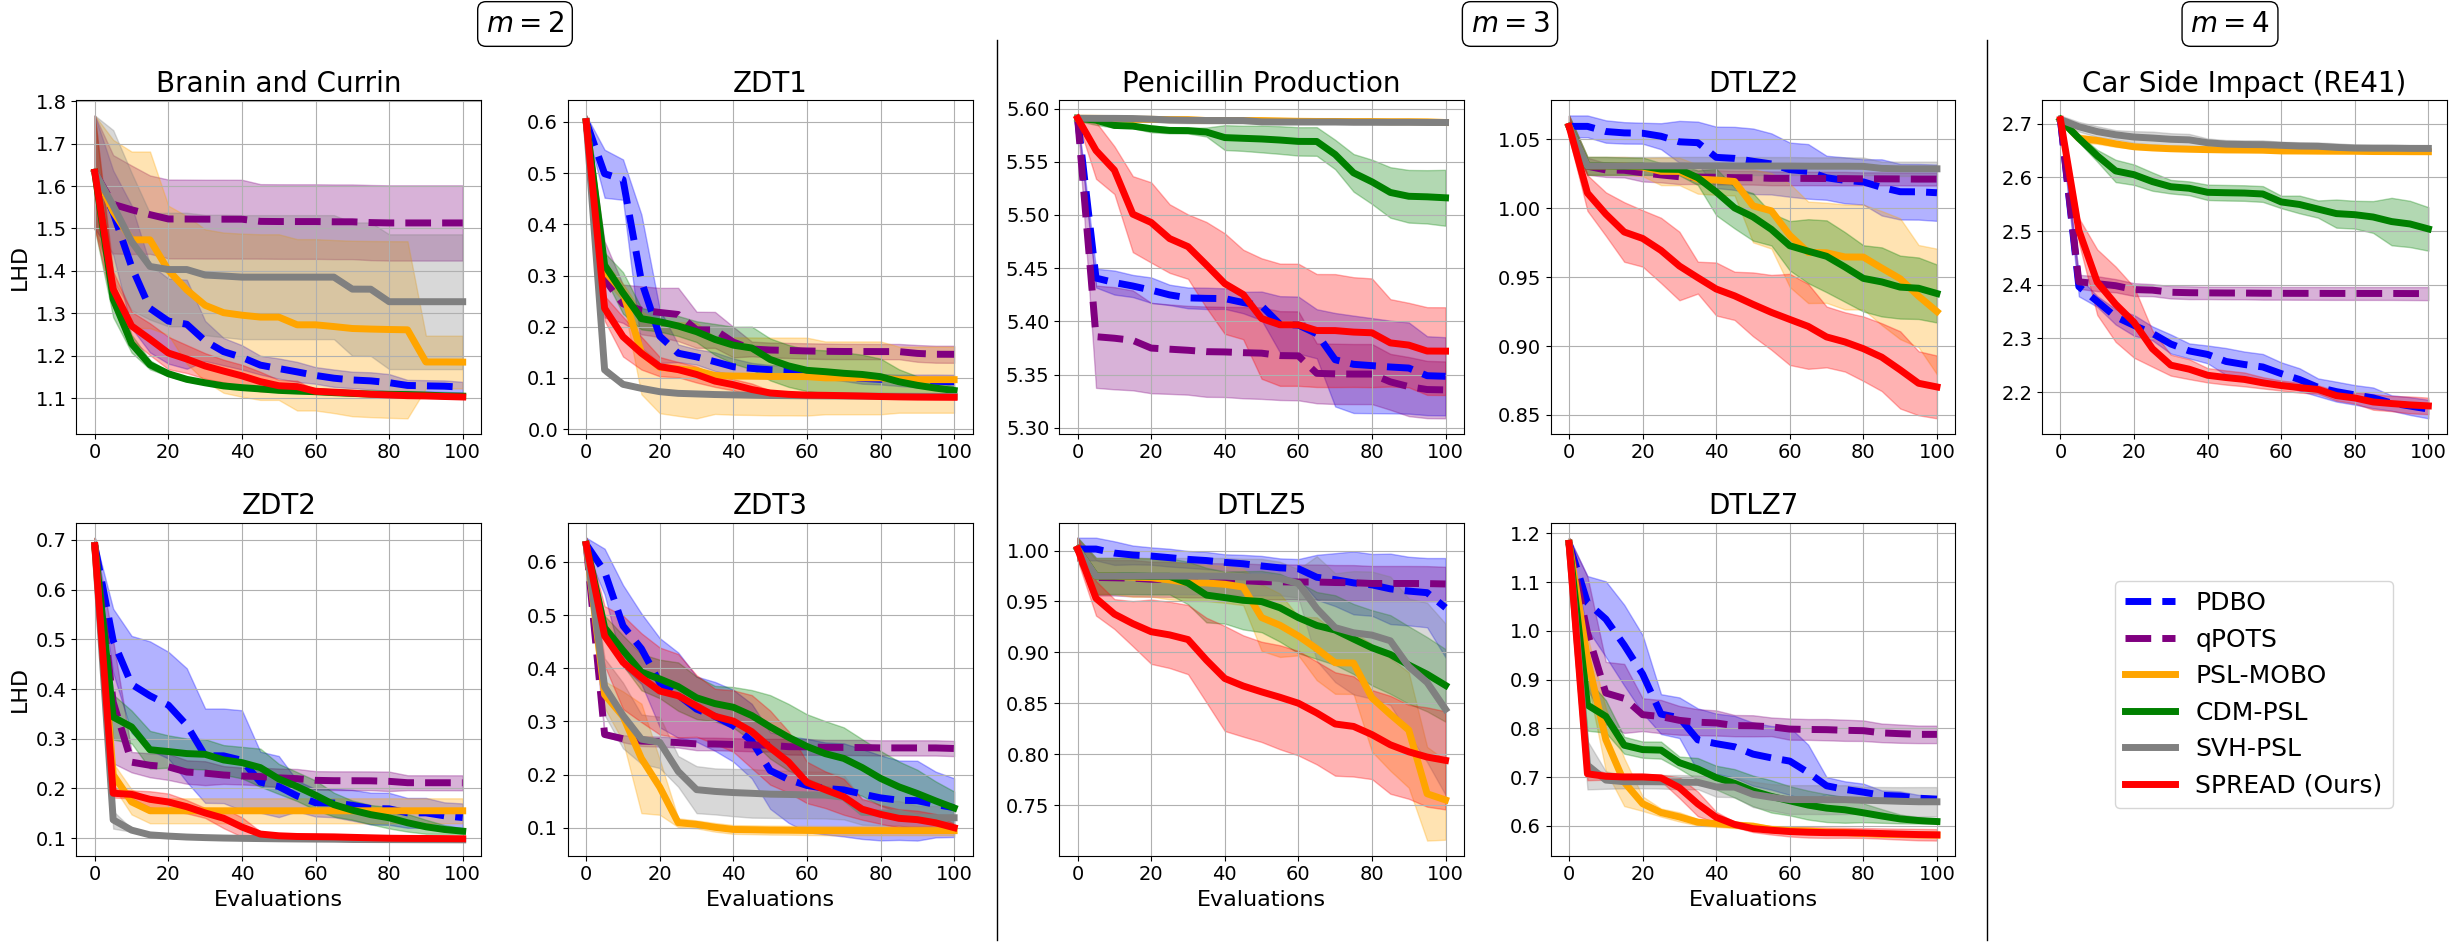

In [ ]:
list_tasks = ["zdt1", "zdt2", "zdt3", "dtlz2", "dtlz5", "dtlz7",  "carside", "penicillin", "branincurrin"]
n_sample = 5
max_fes = 100
list_methods = ["pdbo", "qpots", "psl_mobo", "cdm_psl", "svh_psl", "bay_spread"]
list_names = ["pdbo", "svh-psl", "qpots", "psl-mobo", "cdm-psl", "spread"]
colors = ["blue", "purple", "orange",  "green", "gray",  "red",  "brown", "black",  ]
switch = 1
dict_log_results = {"qpots": "baselines/qpots/logs/saved_hvs/",}

plt_hvs_vs_fes(list_tasks, n_sample, max_fes, 
               list_methods, list_names, 
               switch = switch, colors = colors,
               dict_log_results=dict_log_results, plot_log_diff = True)

## Ablation Study on SBX

In [ ]:
def split_prefix_num(s):
    m = re.match(r"^(.*?)(\d+)$", s)
    return (m.group(1), int(m.group(2))) if m else (s, 0)

def plt_hvs_vs_fes_ablation(list_tasks, n_sample, max_fes, 
                   list_methods, list_names, colors, 
                   plot_log_diff = True, lab = "ablation"):
    
    n_steps = int(max_fes / n_sample)
    
    list_methods =  [m+"*" for m in list_methods] + list_methods
     
    hv_list_loaded = {}
    for method in list_methods:
        hv_list_loaded[method] = {}

    for task in list_tasks:
        
        for method in list_methods:
            use_m = method
            if "*" in method:
                use_m = method[:-1]
            if ("spread" in method):
                log_results = f"logs/saved_hvs/"
            else:
                log_results = f"baselines/{use_m}/logs/saved_hvs/"

            if "*" in method:
                name_t = (
                        use_m
                        + "_"
                        + task
                        + "_K"
                        + str(n_steps)
                        + "_FE"
                        + str(max_fes)
                        + "_pure" 
                    )
            else:
                    name_t = (
                        use_m
                        + "_"
                        + task
                        + "_K"
                        + str(n_steps)
                        + "_FE"
                        + str(max_fes)
                        + "_switch"
                    )
                
            
            outfile = os.path.join(log_results, name_t + ".pkl")
            # skip if file is missing
            if not os.path.exists(outfile):
                print(outfile)
                continue

            with open(outfile, "rb") as f:
                array_hvs = pickle.load(f)

            hv_list_loaded[method][task] = array_hvs
                

    tasks = set.intersection(
            *(set(hv_list_loaded[m].keys()) for m in list_methods)
        )
    desired_order = ["branincurrin", "zdt1",  "penicillin", "dtlz2", "carside", "zdt2", "zdt3", "dtlz5", "dtlz7",]
    tasks = [task for task in desired_order if task in tasks]
    n_plots = len(tasks)
    
    print(f"Number of tasks: {n_plots}")

    ncols = int(math.ceil(math.sqrt(n_plots)))
    nrows = int(math.ceil(n_plots / ncols))
    ncols = 5
    nrows = 2
    
    print(f"n_cols: {ncols}, n_rows: {nrows}")
                            
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), 
                         gridspec_kw={})
    

    # Ensure axes is always a 1-D array
    axes = np.array(axes, ndmin=1).flatten()

    if plot_log_diff:
        for idx, task in enumerate(tasks):
            ax = axes[idx]
            initial_point = np.log10(dict_max_hvs[task] -  min(
                                (hv_list_loaded[m][task][:, 0] for m in list_methods),
                                key=lambda arr: arr.mean()
                            )
            )
            for method in list_methods:
                array_hvs = hv_list_loaded[method][task]
                diff = dict_max_hvs[task] - array_hvs

                array_hvs = np.log10(diff)
                array_hvs[:, 0] = initial_point

                mean_vals = array_hvs.mean(axis=0)
                std_vals  = array_hvs.std(axis=0)
                x = np.arange(20 + 1) * 5

                matches = difflib.get_close_matches(method, list_names, n=1, cutoff=0.6)
                match = matches[0].upper()
                if match == "SPREAD":
                    match = "SPREAD (Ours)"
                ax.errorbar(x, mean_vals, label = match, 
                            color=colors[list_methods.index(method)], 
                            linewidth=5, fmt = '-' if ("psl" in method or "spread" in method) else '--'
                            ) # 2
                ax.fill_between(x, mean_vals-std_vals, mean_vals+std_vals, alpha=0.3,
                                color=colors[list_methods.index(method)])
                
            title_is = task.upper()
            if title_is == "CARSIDE":
                title_is = "Car Side Impact (RE41)"
            elif title_is == "PENICILLIN":
                title_is = "Penicillin Production"
            elif title_is == "BRANINCURRIN":
                title_is = "Branin and Currin"

            ax.set_title(title_is)
            if idx//ncols + 1 >= nrows:
                ax.set_xlabel('Evaluations')
            if idx%ncols == 0:
                ax.set_ylabel('LHD')
            ax.grid()
                
            if idx == len(tasks) - 1:
                h, l = ax.get_legend_handles_labels()
                leg = fig.legend(
                    h,
                    l,
                    loc= "lower right", #"lower center",
                    ncol=1, #+1,
                    bbox_to_anchor=(0.97, 0.22)
                )
                
        pos1 = axes[1].get_position()
        pos2 = axes[2].get_position()
        pos3 = axes[3].get_position()
        pos4 = axes[4].get_position()
        # Midpoint x position in figure coordinates
        addx1 = (0.9*pos1.x1 + 0.98*pos2.x0) / 2
        addx2 = (1.0*pos3.x1 + 1.13*pos4.x0) / 2
        # Add vertical line spanning the subplot heights
        fig.add_artist(plt.Line2D((addx1, addx1), (0.1, 1.0), color="black", lw=1))
        fig.add_artist(plt.Line2D((addx2, addx2), (0.1, 1.0), color="black", lw=1))
        
        fig.text(
            0.216, 1.03, "$m = 2$",
            ha='center', va='top', fontsize=20, color="black",
            bbox=dict(boxstyle="round", facecolor="none", alpha=1.0)
        )
        fig.text(
            0.612, 1.03, "$m = 3$",
            ha='center', va='top', fontsize=20, color="black",
            bbox=dict(boxstyle="round", facecolor="none", alpha=1.0)
        )
        fig.text(
            0.9, 1.03, "$m = 4$",
            ha='center', va='top', fontsize=20, color="black",
            bbox=dict(boxstyle="round", facecolor="none", alpha=1.0)
        )

    else:
        for idx, task in enumerate(tasks):
            ax = axes[idx]
            initial_point = min(
                                (hv_list_loaded[m][task][:, 0] for m in list_methods),
                                key=lambda arr: arr.mean()
                            )
            for method in list_methods:
                array_hvs = hv_list_loaded[method][task]
                array_hvs[:, 0] = initial_point
                mean_vals = array_hvs.mean(axis=0)
                std_vals  = array_hvs.std(axis=0)
                x = np.arange(20 + 1) * 5

                matches = difflib.get_close_matches(method, list_names, n=1, cutoff=0.6)
                ax.errorbar(x, mean_vals, label = matches[0].upper(), 
                            color=colors[list_methods.index(method)], 
                            linewidth=2) 
                ax.fill_between(x, mean_vals-std_vals, mean_vals+std_vals, alpha=0.3, 
                                color=colors[list_methods.index(method)])
            
            title_is = task
            ax.set_title(title_is.upper())
            ax.set_xlabel('Evaluations')
            ax.set_ylabel('Hypervolume')
                
            if idx == 0:
                h, l = ax.get_legend_handles_labels()
                leg = ax.legend(
                    h,
                    l,
                    loc="lower center",
                )

    # Remove any extra axes
    for j in range(n_plots, len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout(rect=[0, 0.1, 1, 1])
    name_img = "exp_bay"
    if lab is not None:
        name_img += f"_{lab}"
    plt.savefig(
        f"plots/{name_img}.jpg",      # .jpg extension tells matplotlib to use JPEG
        dpi=300,            # resolution
        format="jpeg",      # explicit format (optional if extension is .jpg)
        bbox_inches="tight" # crop extra whitespace
    )
    plt.savefig(f"plots/{name_img}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

Number of tasks: 9
n_cols: 5, n_rows: 2


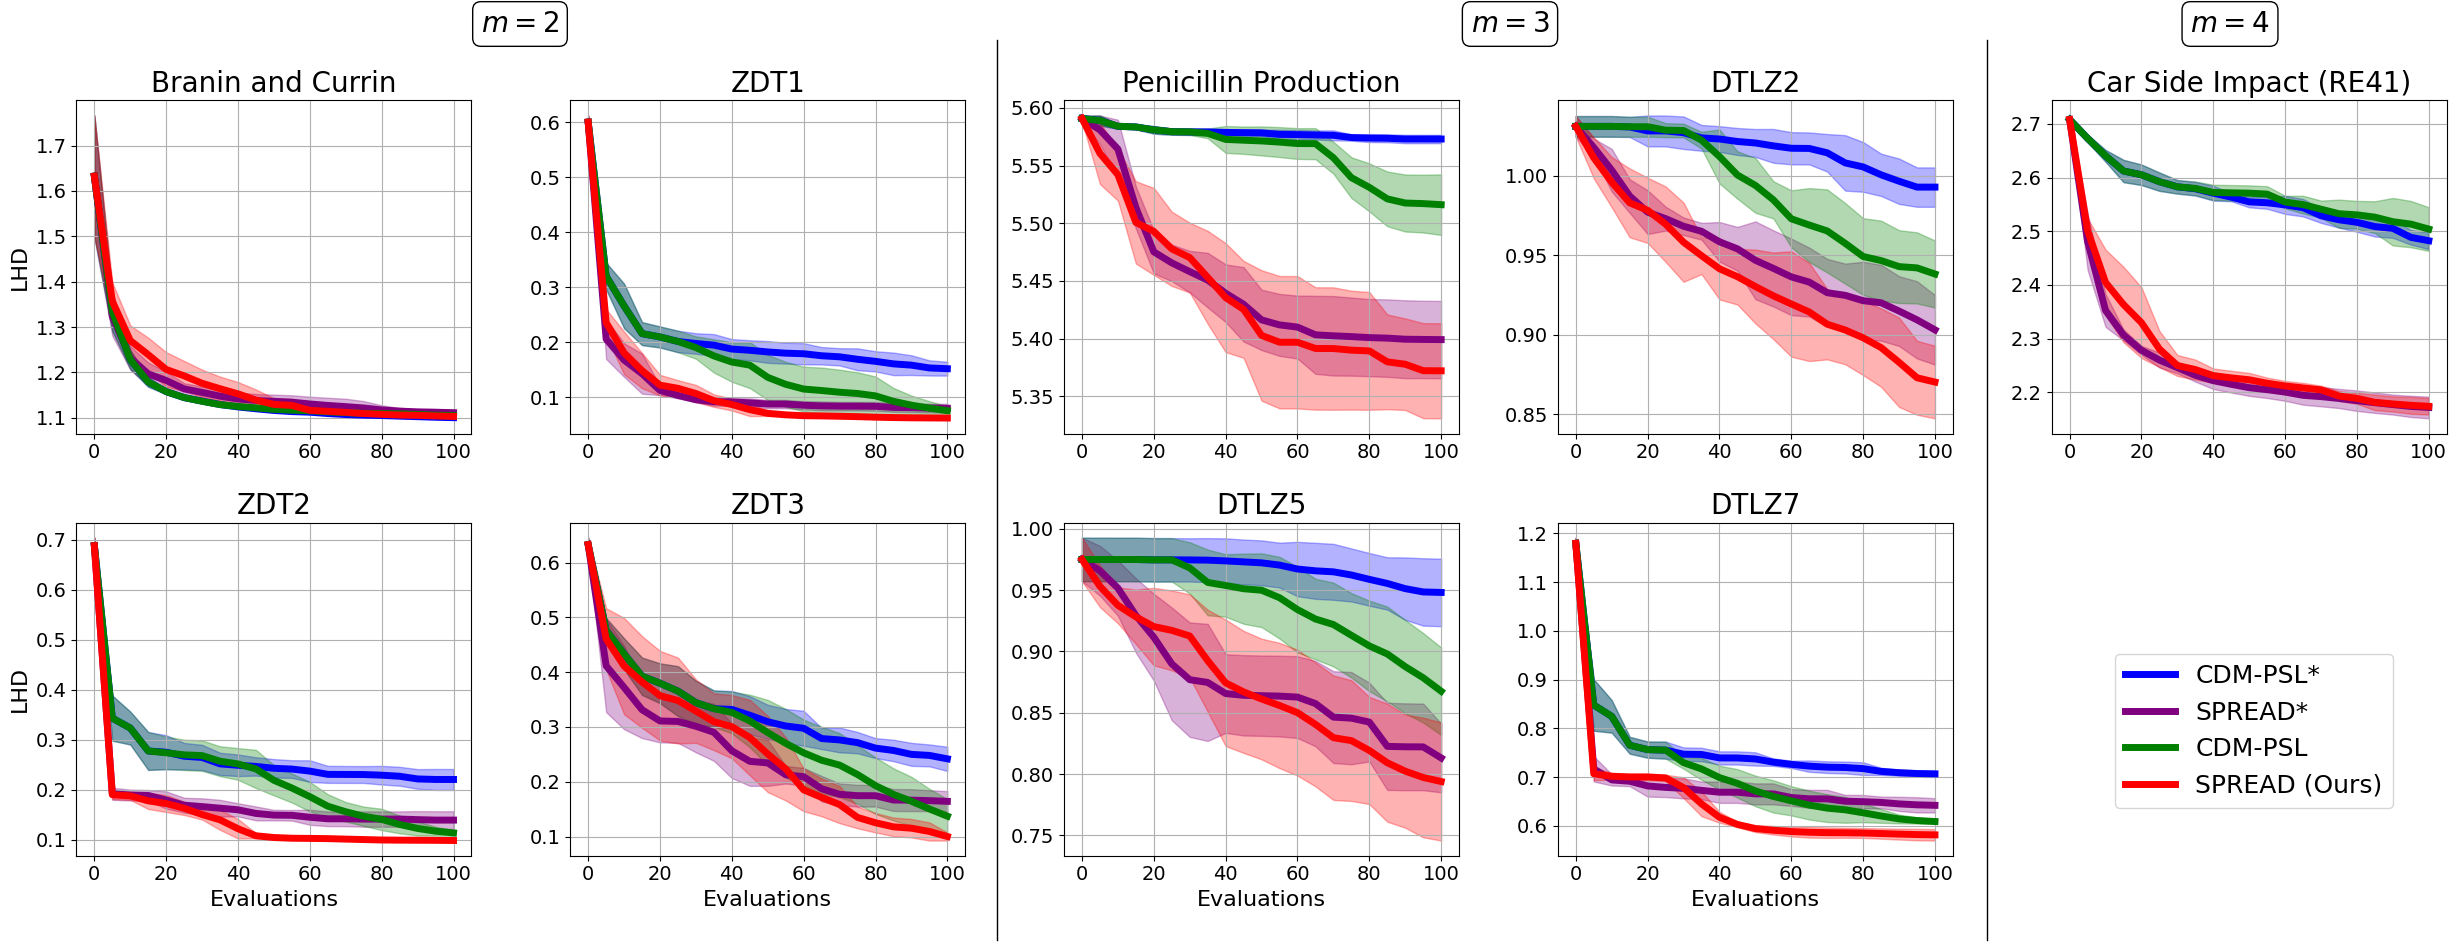

In [ ]:
list_tasks = ["zdt1", "zdt2", "zdt3", "dtlz2", "dtlz5", "dtlz7",  "carside", "penicillin", "branincurrin"]
n_sample = 5
max_fes = 100
list_methods = ["cdm_psl", "bay_spread"]
list_names = ["cdm-psl", "spread", "cdm-psl*", "spread*"]
colors = ["blue",  "purple",  "green", "red",  "orange",   "gray",    "brown", "black",  ]
dict_log_results = {"qpots": "baselines/qpots/logs/saved_hvs/",}

plt_hvs_vs_fes_ablation(list_tasks, n_sample, max_fes, 
               list_methods, list_names, colors = colors,
                plot_log_diff = True, lab = "abla_switch")